In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style, rcParams
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.decomposition import NMF, PCA
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_validate
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.metrics.pairwise import cosine_similarity
import xgboost.sklearn as xgb
import xgboost as x
import gensim
import seaborn as sns
import pickle
import nlp_pipeline as nlp
import ml_functions as ml
# %load_ext autoreload
%autoreload 2
style.use('ggplot')
rcParams['font.size'] = 14
rcParams['legend.fontsize'] = 'small'
rcParams['figure.titlesize'] = 'large'

In [96]:
df = pd.read_csv('../data/train.csv')
df = df[df['Labels'] != 4].copy()
df['target'] = np.where((df['Labels'] == 3) | (df['Labels'] == 5), 0, 1)
df.head(10)

,Labels,Text,Text_Tag,target
0,1,Says the Annies List political group supports ...,abortion,1
1,2,When did the decline of coal start? It started...,"energy,history,job-accomplishments",1
2,3,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,0
3,1,Health care reform legislation is likely to ma...,health-care,1
4,2,The economic turnaround started at the end of ...,"economy,jobs",1
5,5,The Chicago Bears have had more starting quart...,education,0
6,0,Jim Dunnam has not lived in the district he re...,candidates-biography,1
7,2,I'm the only person on this stage who has work...,ethics,1
8,2,"However, it took $19.5 million in Oregon Lotte...",jobs,1
9,3,Says GOP primary opponents Glenn Grothman and ...,"energy,message-machine-2014,voting-record",0


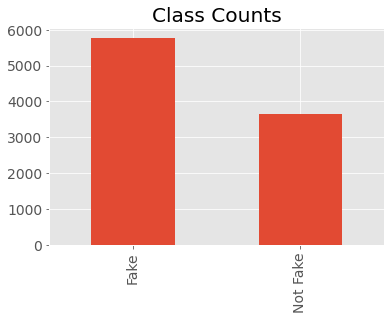

In [149]:
df.target.value_counts().plot(kind='bar')
plt.xticks(df.target.unique(), ['Not Fake','Fake'])
plt.title('Class Counts');

In [98]:
df.target.value_counts()

1    5763
0    3638
Name: target, dtype: int64

In [99]:
corpus = df['Text'].tolist()
y = df['target']
corpus_train, corpus_test, y_train, y_test = train_test_split(corpus, y.values,
                                                            test_size=0.2,
                                                            stratify=y,
                                                            random_state=42)
bow_train = [nlp.extract_bow_from_raw_text(row) for row in corpus_train]
bow_test = [nlp.extract_bow_from_raw_text(row) for row in corpus_test]

In [175]:
X_train, X_test = nlp.word_embed(bow_train, bow_test, size=50)

In [176]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7520, 50)
(1881, 50)
(7520,)
(1881,)


In [152]:
X_train.shape
cosim = cosine_similarity(X_train[2].reshape(1,-1), X_train)

np.min(cosim)

print("True headline:", corpus_train[2])

print("Least similar headline:", corpus_train[np.argmin(cosim)])

True headline: Says Patrick Murphy supports a gun ban on commonly owned semi-automatic firearms used for hunting, recreational shooting and self defense.
Least similar headline: On mandating health care coverage.


In [153]:
y_train[np.argmin(cosim)]

1

In [103]:
np.argwhere(y_train==0)

array([[   2],
       [   3],
       [   8],
       ...,
       [7508],
       [7510],
       [7513]])

In [107]:
np.array(corpus_train)[np.argsort(cosim)]

array([['President Barack Obama supports immigration amnesty.',
        'The countrys bankrupt.',
        'Says Russian President Vladimir Putin calls me brilliant.', ...,
        'Says Marco Rubio voted against every bill that would have helped keep our families safe. He even voted against a bipartisan measure, introduced by a Republican, to prevent people on the no-fly list from purchasing guns.',
        'Republican candidate for governor Allan Fung donated to Democrats like Congressman David Cicilline, disgraced (House) speaker Gordon Fox and even Mr. Obamacare, Harry Reid.',
        'Says Patrick Murphy supports a gun ban on commonly owned semi-automatic firearms used for hunting, recreational shooting and self defense.']],
      dtype='<U3192')

In [146]:
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:,1]
ml.get_scores(y_test, y_pred, y_proba)
# print(classification_report(y_train, rf.predict(X_train)))
# print(classification_report(y_test, y_pred))

# rf.score(X_train, y_train)


              precision    recall  f1-score   support

           0       0.42      0.24      0.31       728
           1       0.62      0.79      0.70      1153

    accuracy                           0.58      1881
   macro avg       0.52      0.52      0.50      1881
weighted avg       0.54      0.58      0.55      1881

[[176 552]
 [243 910]]
ROC AUC: 0.5462404572877253


In [22]:
filename = '../models/wv_rf1.sav'
pickle.dump(rf, open(filename, 'wb'))

In [177]:
params = {
            'n_estimators': [130],
#             'max_features': [40,50,60],
            'max_depth': [4]
         }

rf_be = GridSearchCV(RandomForestClassifier(class_weight='balanced', n_jobs=-1), 
                           params, 
#                            random_state=0, 
                           scoring='roc_auc',
                           return_train_score=True)

search = rf_be.fit(X_train, y_train)
search.best_params_

{'max_depth': 4, 'n_estimators': 130}

In [178]:
y_pred = search.predict(X_test)
y_proba = search.predict_proba(X_test)[:,1]

print('Train:')
ml.get_scores(y_train, search.predict(X_train), search.predict_proba(X_train)[:,1])
print('\nTest:')
ml.get_scores(y_test, y_pred, y_proba)

Train:
              precision    recall  f1-score   support

           0       0.48      0.59      0.53      2910
           1       0.70      0.59      0.64      4610

    accuracy                           0.59      7520
   macro avg       0.59      0.59      0.59      7520
weighted avg       0.61      0.59      0.60      7520

[[1726 1184]
 [1877 2733]]
ROC AUC: 0.6397985851764056

Test:
              precision    recall  f1-score   support

           0       0.45      0.54      0.49       728
           1       0.67      0.58      0.62      1153

    accuracy                           0.56      1881
   macro avg       0.56      0.56      0.55      1881
weighted avg       0.58      0.56      0.57      1881

[[394 334]
 [487 666]]
ROC AUC: 0.586441962200852


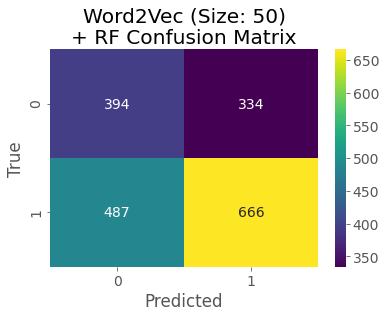

In [180]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g', cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Word2Vec (Size: 50)\n+ RF Confusion Matrix');

In [157]:
alg = xgb.XGBClassifier(
                       n_estimators=500, 
                       learning_rate=0.01,
                       max_depth=3,
                       colsample_bytree=0.8,
                       min_child_weight=3,
                       gamma=0,
                       subsample=0.8,
                       scale_pos_weight=0.62,
                       n_jobs=-1,
                       seed=27)

ml.modelfit(alg, X_train, y_train)

Num of n_estimators: 160

Model Report
              precision    recall  f1-score   support

           0       0.49      0.64      0.56      2910
           1       0.72      0.59      0.65      4610

    accuracy                           0.61      7520
   macro avg       0.61      0.61      0.60      7520
weighted avg       0.63      0.61      0.61      7520

AUC Score (Train): 0.6562091970987917


In [160]:
params = {
             'max_depth': [3,7],    # d-6
#             'reg_alpha': (0, 0.01),       # Lasso (L1) d-0
#             'reg_lambda': (1, 5, 10),   # Ridge (L2)   d-1
             'colsample_bytree': [0.8,0.9],
             'gamma': [0],   # d-0
             'min_child_weight': [3],   # d-1
             'subsample': [0.45,0.7],  # d-1 ... do 0.5 or something in the middle
             'n_estimators': [161,300],
             'scale_pos_weight': [0.62]
         }
gb = xgb.XGBClassifier(learning_rate=0.005, n_jobs=-1)

search = GridSearchCV(gb, 
                           params, 
#                            random_state=0, 
                           scoring='roc_auc',
                           return_train_score=True)
search.fit(X_train, y_train)
search.best_params_

KeyboardInterrupt: 

In [181]:
params = {
             'max_depth': [3],    # d-6
#             'reg_alpha': (0, 0.01),       # Lasso (L1) d-0
#             'reg_lambda': (1, 5, 10),   # Ridge (L2)   d-1
             'colsample_bytree': [0.8],
             'gamma': [0],   # d-0
             'min_child_weight': [3],   # d-1
             'subsample': [0.45],  # d-1 ... do 0.5 or something in the middle
             'n_estimators': [161],
             'scale_pos_weight': [0.62]
         }
gb = xgb.XGBClassifier(learning_rate=0.01, n_jobs=-1)

search = GridSearchCV(gb, 
                           params, 
#                            random_state=0, 
                           scoring='roc_auc',
                           return_train_score=True)
search.fit(X_train, y_train)
search.best_params_

{'colsample_bytree': 0.8,
 'gamma': 0,
 'max_depth': 3,
 'min_child_weight': 3,
 'n_estimators': 161,
 'scale_pos_weight': 0.62,
 'subsample': 0.45}

In [182]:
y_pred = search.predict(X_test)
y_proba = search.predict_proba(X_test)[:,1]

print('Train:')
ml.get_scores(y_train, search.predict(X_train), search.predict_proba(X_train)[:,1])
print('\nTest:')
ml.get_scores(y_test, y_pred, y_proba)

Train:
              precision    recall  f1-score   support

           0       0.48      0.61      0.54      2910
           1       0.70      0.59      0.64      4610

    accuracy                           0.59      7520
   macro avg       0.59      0.60      0.59      7520
weighted avg       0.62      0.59      0.60      7520

[[1763 1147]
 [1913 2697]]
ROC AUC: 0.6405147184888671

Test:
              precision    recall  f1-score   support

           0       0.44      0.55      0.49       728
           1       0.66      0.56      0.61      1153

    accuracy                           0.56      1881
   macro avg       0.55      0.56      0.55      1881
weighted avg       0.58      0.56      0.56      1881

[[403 325]
 [509 644]]
ROC AUC: 0.5891314344805239


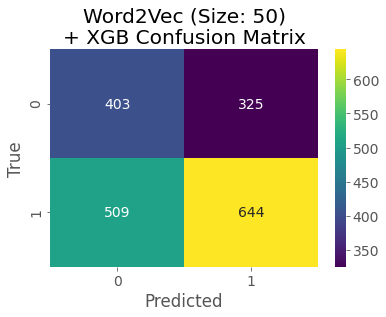

In [183]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g', cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Word2Vec (Size: 50)\n+ XGB Confusion Matrix');

In [138]:
ids = np.argwhere(search.predict(X_train) == 0)[:10,0]

for i in ids:
    print(y_train[i], corpus_train[i],"\n")

1 The fact is, over 2.4 million jobs have been lost since the Stimulus bill was signed into law in February of 2009. 

1 The gun industry isthe only business in America that is wholly protected from any kind of liability. 

0 The 12 hottest years on record have come in the last 15 years. 

0 It used to be the policy of the Republican Party to get rid of the Department of Education. We finally get in charge and a chance to do something, so we double the size of the Department of Education. 

1 We get 30 percent of our oil from the Gulf (of Mexico). 

0 In 2009, Yost spent 2.5 times more money than it took to run the (prosecutors) office before he got there. 

1 In reality, there have been no problems whatsoever with the Texas voter ID law. 

0 Says about 25 Texas cities and 39 states have banned texting while driving. 

0 According to the U.S. Census Bureau, 71.2 percent of Hispanic registered voters in Texas and over 86 percent of African American registered voters participated in the 

In [139]:
ids = np.argwhere(y_pred == 0)[:10,0]

for i in ids:
    print(y_test[i], corpus_test[i],"\n")

0 The shutdown is projected to result in $10 billion in costs to the economy per week. 

0 A part-time Congress with half the pay would still make $38,000 a year more than the average American family. 

0 There are countries in Africa where they have higher vaccination rates than here in the United States. 

0 (M)ore Georgians have jobs than at any other time since October 2008. 

0 Says Virginia, Florida and Georgia are the three states that are the principal source for gun trafficking. 

1 Three years after getting the $100 million (from Mark Zuckerberg), less than two-thirds of students in Cory Bookers Newark graduate. 

1 We worked together to enact ... the largest tax cut in Florida history. 

0 Our pension system is the only one in the country thats 100 percent funded. 

1 Says Apple products are currently 90 percent conflict-free, and Intel is 100 percent conflict-free. 

1 Almost 95 percent of all (Planned Parenthood) pregnancy services were abortions. 



In [140]:
X_train

array([[ 0.01635415, -0.0244457 ,  0.04470503, ..., -0.11840788,
        -0.30970715,  0.05090534],
       [ 0.00277485, -0.05367855,  0.13022987, ..., -0.04322187,
        -0.31264482,  0.04525831],
       [-0.00393693, -0.03115885,  0.06817308, ..., -0.03454947,
        -0.18689619,  0.02228789],
       ...,
       [ 0.03609962, -0.01740077, -0.01754775, ..., -0.1350032 ,
        -0.24196258,  0.03443685],
       [-0.00220916, -0.06254113,  0.1352003 , ..., -0.04204313,
        -0.31485306,  0.04085705],
       [-0.00599753, -0.03402632,  0.05393334, ..., -0.08246064,
        -0.26326106,  0.03284794]])